# **Assignment 4 DAP (Delayed Assessment Scheme)**

### **Time Dependant Problems - Evolution of the heat distribution of a square plate**
Consider a square plate with sides [−1,1]×[−1,1]
. At time t = 0 we are heating the plate up such that the temperature is 𝑢=5
 on one side and 𝑢=0
 on the other sides. The temperature evolves according to:

$$𝑢_{𝑡}=Δ𝑢$$


At what time 𝑡∗
 does the plate reach 𝑢=1
 at the center of the plate?
Implement a finite difference scheme and try with explicit and implicit time-stepping. Numerically investigate the stability of your schemes.

By increasing the number of discretisation points demonstrate how many correct digits you can achieve. Also, plot the convergence of your computed time 𝑡∗
 against the actual time. To 12 digits the wanted solution is 𝑡∗=0.424011387033
.

A GPU implementation of the explicit time-stepping scheme is not necessary but would be expected for a very high mark beyond 80%.

####**Importing modules**

In [ ]:
# Im|porting relevant modules
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import coo_matrix,csc_matrix

from timeit import timeit
import numba
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse import diags, kron, identity,eye,coo_matrix,linalg
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize_scalar
from numba import cuda, float32
import math

#### **Setting the initial Condition of the problem**
The initial condition of the problem is that one side of the 2x2 square surface is heating to u=5 (assuming it is in degrees) and the rest of the points remains at u=0. The boundary condition is such that one side of the square plate is heated to u=5 and the rest of the sides remains at u=0. I have chosen to let the side with u=5 to be the y=1 line. By discretisation, $u(x,y,t) \rightarrow u^{n}_{ij}$ on the grid with points $x_{i}=ih$ and $y_{j}=jh$ in the domain $x,y ∈ [-1,1]$ where we assume the spacing between points $h_{x}=h_{y}=\frac{2}{N-1}$ & N is the number of evenly spaced grid points. Start by defining the function for 2D plot,3D scattered plot & boundary condition.

In [ ]:
def Plot_2D(U,Title):
    '''
    plotting 2D heat distribution

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    U (NxN)- the heat distribution on the 2x2 square plate
    '''
    plt.imshow(U, extent=(-1,1,1,-1))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(Title)
    plt.colorbar().set_label("Temperature in degrees")

def Plot_3D(N,U,Title):
    '''
    plotting 2D heat distribution

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    U (NxN)- the heat distribution on the 2x2 square plate
    Title - setting the title for the 3D plot
    output:
    3D plot of the heat distribution
    '''


    x=np.linspace(-1,1,N)
    y=np.linspace(-1,1,N)
    X,Y=np.meshgrid(x,y)
    assert len(U[0])==len(x) & len(U[1])==len(y)

    # Creating scattered plot
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    scatter=ax.scatter(X, Y, U,c=U, cmap='viridis', marker='o')

    # Label axes
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Temperature')
    # Set axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([0, 5])
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, pad=0.1)
    cbar.set_label("Temp in degrees")
    ax.set_title(Title)
    # Plot
    plt.show()


# Boundary condition function
@numba.jit(nopython =True, parallel=True, fastmath= True)
def Boundary_Condition(U,value=5):
    """Apply Dirichlet boundary conditions."""
    U[0, :] = 0      # Bottom edge (y = -1)
    U[:, 0] = 0      # Left edge (x = -1)
    U[:, -1] = 0     # Right edge (x = 1)
    U[-1, :] = value # Top edge (y = 1)
    return U


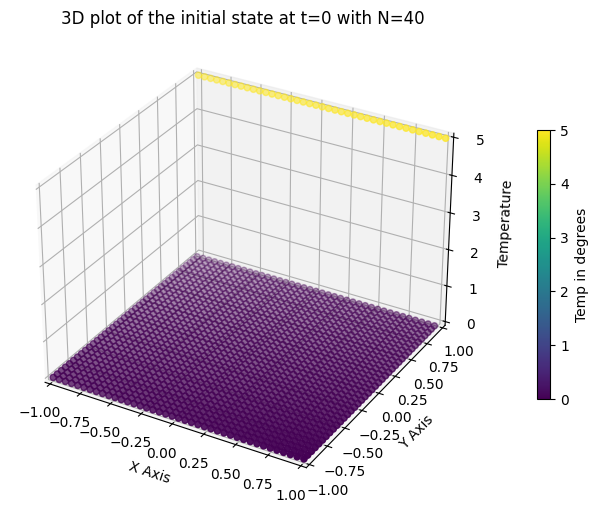

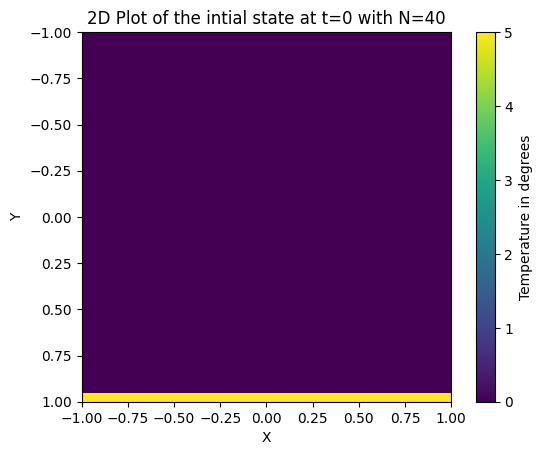

In [ ]:
N=40
U=np.zeros((N,N))
U=Boundary_Condition(U)
# 3D plot of the initial state at t=0
Plot_3D(N,U,f"3D plot of the initial state at t=0 with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U,f'2D Plot of the intial state at t=0 with N={N}')


#### **Temperature Evolution of the square plate**
The Temperature evolves according to:
$$u_{t}=\Delta u$$
There are two methods to implement this differential equations which are the finite difference scheme with either explicit or implicit method for time-stepping.

## **Explicit method**

This method use the current state & derivatives to solve for the next timestep which is called the Euler's Forward Difference:

$$\frac{du}{dt} \approx \frac{u(t+\Delta t)-u(t)}{\Delta t} = \frac{u^{n+1}-u^{n}}{dt}$$  where the superscript n represent the state of the system at $n^{th}$ time-step.

From Week 4 Lecture, the Laplacian of $u_{i,j}$ can be written as:
$$\Delta u = \frac{\partial^2 u_{i,j}}{\partial x^2} +\frac{\partial^2 u_{i,j}}{\partial y^2} \approx \frac{ u^{n}_{i-1,j} - u^{n}_{i,j-1} -4 u^{n}_{i,j} +u^{n}_{i+1,j} +u^{n}_{i,j+1}}{h^2}$$
where h is the spacing between grid point as described previously $h_{x}=h_{y}=h$

Hence our explicit iterative scheme is:
$$u^{n+1}_{i,j}= u^{n}_{i,j} + \frac{dt}{h^2} \left( u^{n}_{i-1,j} - u^{n}_{i,j-1} -4 u^{n}_{i,j} +u^{n}_{i+1,j} +u^{n}_{i,j+1} \right) $$

We identify the Courant number as:
$$C=\frac{dt}{h^2}$$
 Courant-Friedrichs-Lewy (CFL) condition for stability is:
 $$C \leq \frac{1}{4}$$

Our explicit iterative scheme becomes:
$$u^{n+1}_{i,j}= u^{n}_{i,j} + C \left( u^{n}_{i-1,j} - u^{n}_{i,j-1} -4 u^{n}_{i,j} +u^{n}_{i+1,j} +u^{n}_{i,j+1} \right) $$

We can represent the 2D Laplacian operator in matrix, we first define our 1D Laplacian operator in matrix A:
$$A=tridiag\left(1,-2,1\right)$$
2D Laplacian operator in matrix:
$$\Delta_{2D} = A \otimes I + I \otimes A $$
where $I$ is the identity & A is the 1D Laplacian operator matrix.

Our Explicit Matrix iterative scheme becomes:
$$u^{n+1}_{i,j}= u^{n}_{i,j} + C \Delta_{2D} u^{n}_{i,j} $$

Explicit method Stability  Proof:
We start with our explicit iterative scheme
$$u^{n+1}_{i,j}= u^{n}_{i,j} + C \left( u^{n}_{i-1,j} - u^{n}_{i,j-1} -4 u^{n}_{i,j} +u^{n}_{i+1,j} +u^{n}_{i,j+1} \right) $$



1. Using Fourier Transform $u^{n}_{i,j}= \hat{u}^{n} e^{i(k_{x} x_{i} + k_{y} y_{i})}$, we can transform our explicit iterative scheme into:

$$\hat{u}^{n+1} = \hat{u}^{n} \left( 1+ C\left(e^{-ik_{x}h} +e^{ik_{x}h}+e^{-ik_{y}h} +e^{ik_{y}h} -4\right) \right)$$

2. Using Trigonometry identities: $e^{i\theta}+ e^{-i\theta}= 2cos(\theta)$
$$\hat{u}^{n+1} = \hat{u}^{n} \left( 1+ C\left(2cos(k_{x}h) + 2cos(k_{y}h) -4\right)\right)$$

3. Define $\xi = cos(k_{x}h) + cos(k_{y}h)$:
$$\hat{u}^{n+1} = \hat{u}^{n} \left(1-4C+2C \xi\right)$$

4. We identify the factor：
$$\mid G\mid = \mid 1 - 4C + 2C\xi \mid \le1$$

5. The maximum value of G is:
$$G = 1$$

6. The minimum value of G is:
$$G = 1-8C$$

7. For stability, $\mid G \mid\le1$, our inequality is:
$$-1\le 1-8C\le 1$$
$$0\le 8G \le 2 $$

Hence Courant-Friedrichs-Lewy (CFL) condition for stability is:
$$0\le C \le \frac{1}{4}$$


#### **Non-Matrix Explicit method: finding t when centre of square plate become u=1**
In this section, we will try to find the time t when the centre of the square plate becomes u=1 using the finite difference scheme with non-matrix explicit method for time-stepping. The detail of the mathematics have been addressed above in the section with title "**Explicit method**". By using Numba's JIT (just-in-time) to enable compilation at run time, we have highly optimised the non-matrix explicit method functions to gain as much performance as possible.

In [ ]:
# Non-Matrix Explicit method's time-stepping function
@numba.jit(nopython =True, parallel=True, fastmath= True)
def explicit_step(U,N,C):
    '''
    Implementing the explicit method for time-stepping

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    Output:
    return the next time-step state u_(n+1)
    '''


    U_updated = np.zeros((N,N))
    # we assume both x-y axis have the same number of evenly spaced grid points
    # Only Update the inner points
    for i in numba.prange(1, N - 1):
        for j in range(1, N - 1):
            U_updated[i, j] = U[i, j] + C * (U[i+1, j] - 4*U[i, j] + U[i-1, j]\
                                      + U[i, j+1] + U[i, j-1])
    return U_updated


# Non-Matrix Explicit method for finding time t
@numba.jit(nopython =True, parallel=True, fastmath= True)
def explicit_method(N,C):
    '''
    Evolving the system using explicit method until the centre of the square
    plate become u=1 and finding t

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant number

    Output:
    U - Heat distribution when the centre of the plate reaches u=1
    t - time when the centre of the plate reaches u=1
    Iteration_count - number of iteration to reach u=1
    '''

    # Setting up for explicit method
    N_exp=N
    h_exp = 2 / (N_exp- 1)  # Grid spacing
    # Choosing Time step such that Courant number is the one we set
    dt_exp = C * (2 / (N_exp- 1))**2
    C_num_exp = C

    # Heat distribution set-up for propagation via explicit method
    U_exp=np.zeros((N_exp,N_exp))
    U_exp=Boundary_Condition(U_exp)

    # time-tracking
    time_exp = 0

    # Index representing the mid-point of the square-plate (0,0),since the x
    # and y axis have the same N, we have the following:
    center_index = N//2

    # Counting number of iteration
    Iteration_count = 0

    # Tracking the temperature of the center of the square plate
    Center_Temp = []

    # Setting a while loop with condition to keep evolving until the centre of
    # the plate (0,0) reaches u=1
    while U_exp[center_index,center_index]<1:
        U_exp = explicit_step(U_exp,N_exp,C_num_exp)
        U_exp = Boundary_Condition(U_exp)
        time_exp += dt_exp
        Iteration_count += 1
        Center_Temp.append(U_exp[center_index,center_index])

    return U_exp,time_exp,Iteration_count,Center_Temp



UsageError: Line magic function `%%timeit` not found.


For explicit method, the computed t is  0.42403026422295215 for (0,0)        to reach u=1.
For explicit method, the number of iteration is  9003 for         (0,0) to reach u=1.


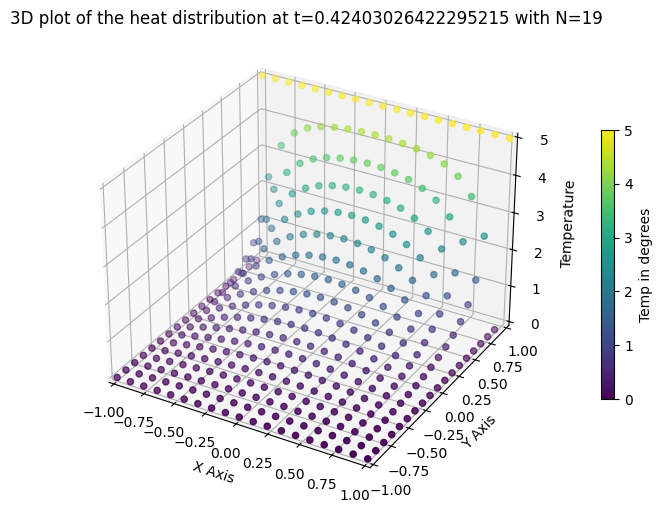

683 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


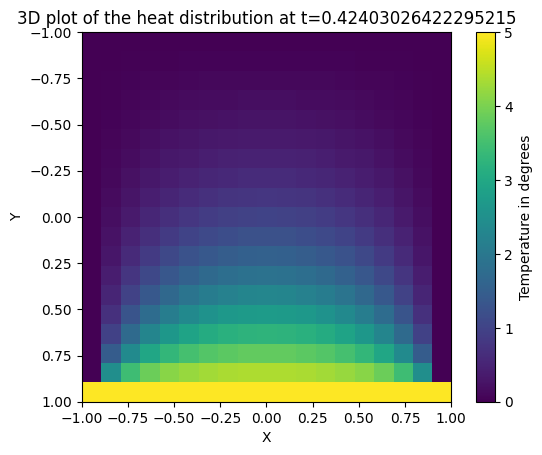

In [ ]:
%%timeit -n1 -r1
N=19
C=0.003815000711102075


U_exp,time_exp,Iteration_count,Center_Temp=explicit_method(N,C)
print("For explicit method, the computed t is ",time_exp, "for (0,0)\
        to reach u=1.")
print("For explicit method, the number of iteration is ",Iteration_count, "for\
         (0,0) to reach u=1.")
# 3D plot of the initial state at t=0
Plot_3D(N,U_exp,f"3D plot of the heat distribution at t={time_exp} with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U_exp,f"3D plot of the heat distribution at t={time_exp}")
t=0.424011387033

#### Comment on the result of the non-matrix explicit method
By choosing a small C and N=19, we have found the time $t = 0.42403026422295215$ when the center of the square plate reaches u=1 (after 9003 time step/ iteration) and plotted the 2D & 3D plot of the square plate at that time.
The reason we are choosing a small C is because the time step dt is:
$$dt = C * \frac{4}{(N-1)^{2}} $$
Hence by choosing a smaller C, we can have a small step-size for every time-step hence allowing us to be more accurate. In general, by increasing N or decreasing C, we would get a more accuracy estimated time t. \\

This estimated time is correct up to 4dp when compare to the wanted $t_{*}=0.424011387033$

#### **Explicit Matrix method: finding t when centre of square plate become u=1**
In this section, we will try to find the time t when the centre of the square plate becomes u=1 using the finite difference scheme with matrix explicit method for time-stepping. The detail of the mathematics have been addressed above in the section with title "**Explicit method**".



In this matrix method, we treat the 2D heat distribution state $u^{n}_{i,j}$ as a vector by flattening the array. After applying the matrix operation to the 2D distribution state, we just reshape the flatten 2D heat distribution state array into (N,N) shape.  Due to us flattening the array, we are using different indexing convention:
$$u_{i,j} \rightarrow j*N+i$$
in order to address the element of $u^{n}_{i,j}$.

We have represented the Laplacian operator as a sparse matrix with boundary condition applied to it and store it in CSC format efficiently in memory.


In [ ]:
def Matrix_2D_Laplacian(N):
    '''Generate the matrix for the 2D Laplacian operator with Boundary Condition
    and return a CSC matrix

    Input:
    N - number of evenly spaced grid points (discretisation parameter)


    Output:
    2D Laplacian matrix with boundary condition applied in CSC format
    '''
    # grid space along the x,y axis


    #size of matrix
    size = N**2

    # The 2D Poisson operator matrix form
    main_diag = -4  * np.ones(size)
    side_diag =  np.ones(size - 1)
    up_down_diag =  np.ones(size - N)

    # Correct side diagonals to avoid connections across row boundaries
    for i in range(1, N):
        side_diag[i * N - 1] = 0  # Set to zero across boundaries

    # Create the matrix
    diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
    offsets = [0, -1, 1, -N, N]
    A = diags(diagonals, offsets, shape=(size, size), format='coo')

    # Finding the boundary conditions index: since our matrix is N**2 x N**2
    # hence we adopted the index rule (j*N +1)
    boundary_indices = []
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                index = j * N + i
                boundary_indices.append(index)

    # Apply the Boundary Condition
    for idx in boundary_indices:
        # remove all the data at the boundary index
        A.data[A.row == idx] = 0
        A.row = np.append(A.row, idx)
        A.col = np.append(A.col, idx)
        # Set diagonal to 1 at boundary index
        A.data = np.append(A.data, 1.0)

    return A.tocsc()


def explicit_matrix(N,C):
    '''
    Implement the explicit time-stepping using matrix method

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant Number

    output:
    Final_U_exp - Heat distribution when the centre of the plate reaches u=1
    time_exp - estimated time when the centre of the plate reaches u=1
    Iteration_count - number of iteration (number of dt) to reach u=1
    Center_Temp - temperature of the center of the square plate at each iteration
    '''

    # Setting up for explicit method
    N_exp=N
    h_exp = 2 / (N_exp- 1)  # Grid spacing
    # Choosing Time step such that Courant number is the one we set
    dt_exp = C * h_exp**2
    C_num_exp = dt_exp/h_exp**2

    # Heat distribution set-up for propagation via explicit method
    U_exp=np.zeros((N_exp,N_exp))
    U_exp=Boundary_Condition(U_exp)

    # 2D Laplacian operator matrix
    L_2D_exp = Matrix_2D_Laplacian(N_exp)

    # Treating Heat distribution as a vector acted upon by the 2D Laplacian
    U_exp_flat = U_exp.flatten()

    # time-tracking
    time_exp = 0

    # Index representing the mid-point of the square-plate (0,0)
    center_index = (N//2) * N + (N//2)

    # Counting number of iteration
    Iteration_count = 0

    # Tracking the temperature of the center of the square plate
    Center_Temp = []

    # Setting a while loop with condition to keep evolving until the centre of
    # the plate (0,0) reaches u=1
    while U_exp_flat[center_index]<1:

        U_exp_flat = U_exp_flat +  C_num_exp*(L_2D_exp @ U_exp_flat)
        # I haven't apply boundary condition to the 2D Laplacian operator
        # matrix but I have perform the boundary condition setting here

        U_exp_flat=Boundary_Condition(U_exp_flat.reshape(N_exp,N_exp)).flatten()
        time_exp += dt_exp
        Iteration_count += 1

        Center_Temp.append(U_exp_flat[center_index])

    # Final Heat Distribution reshape
    Final_U_exp = U_exp_flat.reshape(N,N)

    return Final_U_exp,time_exp,Iteration_count,Center_Temp



The computed t is  0.4240302642229517 for (0,0) to reach u=1.
The number of iteration is  9003 for (0,0) to reach u=1.


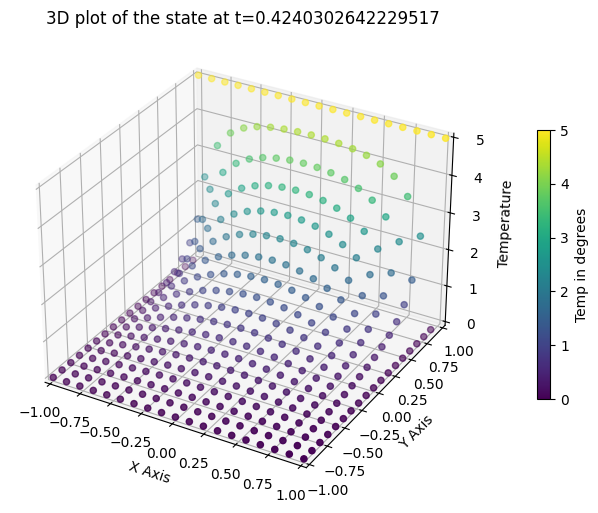

1.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


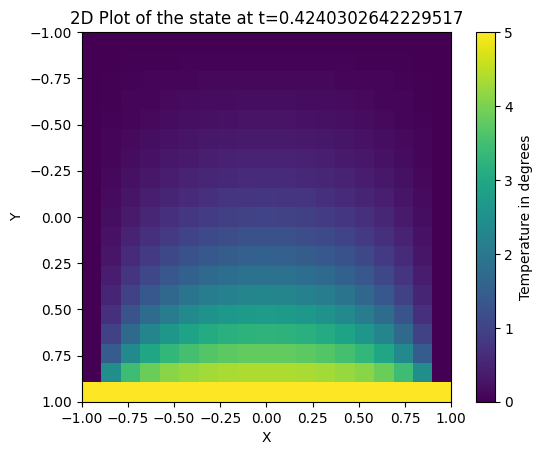

In [ ]:
%%timeit -n1 -r1
N=19
C=0.0038150007111020
U_exp_mat,time_exp_Mat,Iter_count_Mat,Center_Temp_mat_exp=explicit_matrix(N,C)
print("The computed t is ",time_exp_Mat, "for (0,0) to reach u=1.")
print("The number of iteration is ",Iter_count_Mat, "for (0,0) to reach u=1.")

# 3D plot of the initial state at t=0
Plot_3D(N,U_exp_mat,f"3D plot of the state at t={time_exp_Mat}")
# 2D plot of the initial state at t=0
Plot_2D(U_exp_mat,f'2D Plot of the state at t={time_exp_Mat}')

t=0.424011387033

#### Comment on the result of the matrix explicit method
By choosing a small C and N=19, we have found the time $t = 0.42403026422295217$ when the center of the square plate reaches u=1 (after 9003 time step) and plotted the 2D & 3D plot of the square plate at that time. This estimated time is correct up to 4dp when compare to the wanted $t_{*}=0.424011387033$. Hence both the non-matrix and the matrix explicit method give the same estimated time t.

#### **GPU implementation of the explicit time-stepping scheme**
In this section, we have implemented a GPU version (CUDA) of our non-matrix explicit iterative scheme:
$$u^{n+1}_{i,j}= u^{n}_{i,j} + \frac{dt}{h^2} \left( u_{i-1,j} - u_{i,j-1} -4 u_{i,j} +u_{i+1,j} +u_{i,j+1} \right) $$
which leverage multithreading to boost the performance of our calculation. Due to multithreading, we would expect GPU implemented explicit method's computational time to be less than the matrix or non-matrix explicit time in large N. Furthermore to push for even more performance, we have make use of shared memory between blocks/ threads. As global memory accesses on GPUs are expensive, we can use shared memory to reduces the number of global memory transactions and significantly improves performance.

In [ ]:

@cuda.jit
def GPU_explicit_kernel_shared(U_exp_gpu, U_update_exp_gpu, N, C, U_center_exp):
    '''
    Implement the GPU_explicit time-stepping with shared memory/ shared kernel

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant Number
    U_center_exp - temperature of the center of the square plate at each iteration
    U_exp_gpu - Heat distribution at time-step n
    U_update_exp_gpu - Heat distribution at time-step n+1


    '''
    # Shared memory block
    shared_mem = cuda.shared.array(shape=(68, 68), dtype=np.float64)

    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    bdx, bdy = cuda.blockDim.x, cuda.blockDim.y

    # Global indices
    i, j = bx * bdx + tx, by * bdy + ty

    # Load values into shared memory
    if i < N and j < N:
        shared_mem[tx + 1, ty + 1] = U_exp_gpu[j * N + i]

        if ty == 0 and j > 0:
            shared_mem[tx + 1, ty] = U_exp_gpu[(j - 1) * N + i]
        if ty == bdy - 1 and j < N - 1:
            shared_mem[tx + 1, ty + 2] = U_exp_gpu[(j + 1) * N + i]
        if tx == 0 and i > 0:
            shared_mem[tx, ty + 1] = U_exp_gpu[j * N + i - 1]
        if tx == bdx - 1 and i < N - 1:
            shared_mem[tx + 2, ty + 1] = U_exp_gpu[j * N + i + 1]


    cuda.syncthreads()

    # Update Explicit Scheme (time-stepping)
    if 1 <= i < N - 1 and 1 <= j < N - 1:
        U_update_exp_gpu[j * N + i] = shared_mem[tx + 1, ty + 1] + C * (
            shared_mem[tx, ty + 1] + shared_mem[tx + 2, ty + 1] +
            shared_mem[tx + 1, ty] + shared_mem[tx + 1, ty + 2] -
            4 * shared_mem[tx + 1, ty + 1]
        )

        # Taking the temperature value of the center of the square plate
        if i == N // 2 and j == N // 2:
            U_center_exp[0] = U_update_exp_gpu[j * N + i]

def GPU_explicit(N, C, max_time=1):
    """
    Optimized explicit method using GPU with center temperature check.

    Inputs:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant Number
    Max - Total simulation time

    """
     # Setting up for explicit method
    N_exp=N
    h_exp = 2 / (N_exp- 1)  # Grid spacing
    # Choosing Time step such that Courant number is the one we set
    dt_exp = C * h_exp**2
    C_num_exp = dt_exp/h_exp**2
    max_timestep = int(max_time / dt_exp)
    tpb=(32, 32)

    # Heat distribution set-up (initial condition)
    U_exp = np.zeros((N, N), dtype=np.float64)

    # Boundary Condition
    U_exp = Boundary_Condition(U_exp)

    # Treat U as a vector
    U_exp = U_exp.flatten()

    # Copy data to GPU
    U_exp_gpu = cuda.to_device(U_exp)
    U_exp_update_gpu = cuda.to_device(U_exp)
    U_exp_center_gpu = cuda.to_device(np.zeros(1, dtype=np.float64))

    bpg_x = math.ceil((N + tpb[0] - 1) // tpb[0])
    bpg_y = math.ceil((N + tpb[1] - 1) // tpb[1])
    bpg = (bpg_x, bpg_y)

    # Tracking temperature of the center of the square plate
    Center_Temp = []
    Iteration = 0
    # Time-stepping loop
    time_gpu = 0.0
    while True:
        GPU_explicit_kernel_shared[bpg,tpb](U_exp_gpu,U_exp_update_gpu,\
                                            N,C,U_exp_center_gpu)

        cuda.synchronize()

        # Check the center temperature
        U_exp_center = U_exp_center_gpu.copy_to_host()[0]
        Center_Temp.append(U_exp_center)
        if U_exp_center >= 1.0:
            time_gpu += dt_exp
            Iteration += 1
            break

        # Swap the updated and non-update heat distribution for next iteration
        U_exp_gpu, U_exp_update_gpu = U_exp_update_gpu, U_exp_gpu
        time_gpu += dt_exp
        Iteration += 1

    # Copy result back to CPU
    Final_u_exp_gpu = U_exp_gpu.copy_to_host().reshape(N, N)
    return Final_u_exp_gpu, time_gpu, Iteration, Center_Temp



/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


The computed t is  0.42403026422295215 for (0,0) to reach u=1.
The number of iteration is  9003 for (0,0) to reach u=1.


The computed t is  0.4240302642229517 for (0,0) to reach u=1.
The number of iteration is  9003 for (0,0) to reach u=1.


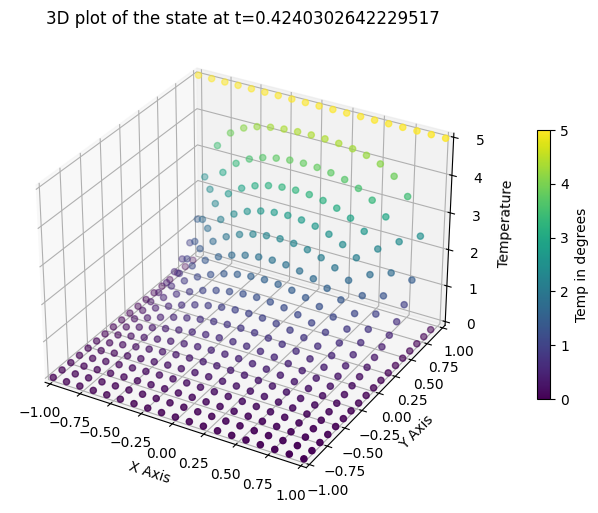

2.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


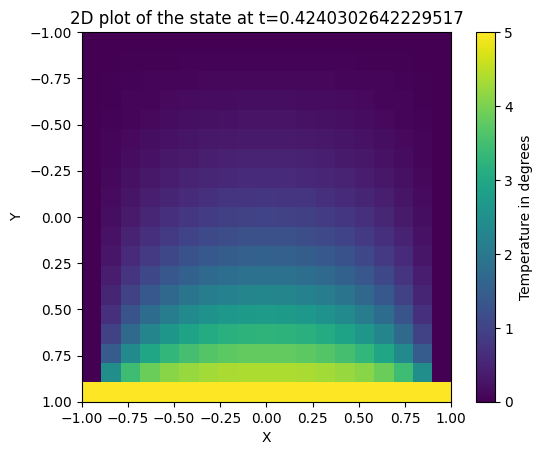

In [ ]:
%%timeit -n1 -r1
N = 19  # Grid size
C = 0.0038150007111020  # Courant number
U_exp_gpu,time_exp_gpu,Iter_count_gpu,Center_Temp_mat_gpu= GPU_explicit(N, C)
print("The computed t is ",time_exp_gpu, "for (0,0) to reach u=1.")
print("The number of iteration is ",Iter_count_gpu, "for (0,0) to reach u=1.")
# 3D plot of the initial state at t=0
Plot_3D(N,U_exp_gpu,f"3D plot of the state at t={time_exp_gpu}")
# 2D plot of the initial state at t=0
Plot_2D(U_exp_gpu,f"2D plot of the state at t={time_exp_gpu}")


#### Comment on the result of the non-matrix explicit method
By choosing a small C and N=19, we have found the time $t = 0.42403026422295217$ when the center of the square plate reaches u=1 (after 9003 time step/ iteration) and plotted the 2D & 3D plot of the square plate at that time. This estimated time is correct up to 4dp when compare to the wanted $t_{*}=0.424011387033$.

Hence all explicit methods (non-matrix, matrix, GPU) gives the same estimated time t.

## **Implicit Method**

Implicit method differed from the explicit method because the next timestep is not solely dependent on the current state but also depends on the next timestep state hence we would need to solve a system of linear equation. The heat equation is given as:

$$\frac{\partial u}{\partial t} = \Delta u$$

By discretisation, the implicit finite difference method with Backward Euler time-stepping is:

$$\frac{\partial u}{\partial t} \approx \frac{u(t) - u(t-\Delta t)}{\Delta t} = \frac{u(t+\Delta t) -u(t)}{\Delta t} = \frac{u^{n+1}_{i,j} - u^{n}_{i,j}}{\Delta t}$$

$$\Delta u = \Delta u^{n+1}_{i,j} = \frac{1}{\Delta x^2} \left( u^{n}_{i-1,j} - u^{n}_{i,j-1} -4 u^{n}_{i,j} +u^{n}_{i+1,j} +u^{n}_{i,j+1} \right) = \frac{1}{\Delta x^2} A $$

where matrix A represent the 2D Laplacian operator.

By making $u^{n+1}_{i,j}$ the subject & define C = $\frac{\Delta t}{\Delta x^2}$ we obtain:

$$u^{n+1}_{i,j}=u^{n}_{i,j}+ C A u^{n+1}_{i,j}$$

This is the implicit iterative scheme:
$$(I - CA) u^{n+1}_{i,j} = u^{n}_{i,j}$$

$$ M u^{n+1}_{i,j} = u^{n}_{i,j}$$ where $M=(I-CA)$



By rearranging our implicit iterative scheme:
$$u^{n+1}_{i,j} = \frac{1}{M} u^{n}_{i,j}$$
we observed that the implicit iterative scheme is unconditionally stable as
$$\frac{1}{M} = \frac{1}{|I-CA|} \le 1$$
is always satisfied no matter what the value of the Courant number is.


Hence in implicit matrix iterative scheme, we propagate the 2D heat distribution state by solving the system of linear equation for every time-step. Below, we will use two different method to solve the system of linear equations:


1.   Scipy's Spsolver (slow method)
2.   Scipy's Cgsolver with Incomplete LU Decomposition preconditioning (fast method) - the reason we can use Cgsolver in this situation is because our matrix is a symmetric positive definite matrix as shown by $\frac{1}{M}$


Stability Proof for the implicit Method:
1. The implicit iterative scheme is $(I-CA) u^{n+1}=u^{n}$ and we identify that $M=(I-CA)^{-1}$ is our amplication matrix.
2. The stability of the scheme depends on the eigenvalues of M & we let $\lambda$ & $\mu$ be an eigenvalue of A & M respectively. Hence
$$\mu = \frac{1}{1-C\lambda}$$
3. The eigenvalue of our 2D Laplacian operator are:
$$\lambda = \frac{4}{h^2} \left(sin^{2}\left(\frac{k_{x} h}{2}\right) +sin^{2}\left(\frac{k_{y}h}{2}\right)\right) \le 0$$
4. Our $\mu$ range should then be: Since $\lambda\le 0, 1-C\lambda> 0$:
$$\mid\mu\mid=\mid\frac{1}{1-C\lambda}\mid\le 1$$
5. Hence Implicit iterative scheme is unconditionally stable.






#### **Matrix Implicit iterative method 1: Scipy's Spsolver (slow method)**
In this method, we have propagated the $u^{n}_{i,j}$ with the implicit iterative scheme where we have to solve the system of linear equation $M u^{n+1}_{i,j} = u^{n}_{i,j}$ using Scipy's Spsolver within every loop.

In [ ]:
def Matrix_M(N, C):
    """
    Create the matrix M described in the implicit method section

    Inputs:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant Number

    Outputs:

    Matrix M
    """

    M = np.zeros((N ** 2, N ** 2))

    # (Identity - Matrix A)
    for n in numba.prange(N ** 2):
        M[n, n] = 1 + 4 * C
        if n - N >= 0:
            M[n, n - N] = - C
        if n + N < N**2:
            M[n, n + N] = - C
        if (n + 1) % N != 0:
            M[n, n + 1] = - C
        if n % N != 0:
            M[n, n - 1] = - C



    # Boundary Condition
    for n in numba.prange((N - 1) * N, N ** 2):
        M[n, :] = 0
        M[n, n] = 1
    for n in numba.prange(N):
        M[n, :] = 0
        M[n, n] = 1
    for n in numba.prange(1, N-1):
        M[n * N, :] = M[n * N + N - 1,:] = 0
        M[n * N, n * N] = M[n * N + N - 1, n * N + N - 1] = 1

    return csc_matrix(M)

def implicit_method_spsolver(N,C,tol=1e-8):
    '''
    Evolving the system using explicit method until the centre of the square
    plate become u=1 and finding t

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant number

    Output:
    U - Heat distribution when the centre of the plate reaches u=1
    t - time when the centre of the plate reaches u=1
    Iteration_count - number of iteration to reach u=1
    '''

    # Setting up for explicit method
    N_imp=N
    h_imp = 2 / (N_imp- 1)  # Grid spacing
    # Choosing Time step such that Courant number is the one we set
    dt_imp = C * h_imp**2
    C_num_imp = dt_imp/h_imp**2

    # Heat distribution set-up for propagation via matrix implicit method
    U_imp=np.zeros((N_imp,N_imp))
    U_imp=Boundary_Condition(U_imp)



    # 2D Laplacian Matrix
    M_matrix = Matrix_M(N_imp,C)



    # time-tracking
    time_imp = 0

    # Index representing the mid-point of the square-plate (0,0),since the x
    # and y axis have the same N, we have the following:
    center_index = N//2

    # Counting number of iteration
    Iteration_count = 0

    # Preconditioner (Incomplete LU Decomposition)
    #preconditioner = linalg.spilu(M_matrix)
    #M_inv = linalg.LinearOperator(M_matrix.shape, preconditioner.solve)

    # Tracking temperature of the center of the square plate
    Center_Temp = []

    # Setting a while loop with condition to keep evolving until the centre of
    # the plate (0,0) reaches u=1
    while U_imp[center_index,center_index]<1:

        # Treat U_imp as a vector
        U_imp=U_imp.flatten()


        U_imp_update = spsolve(M_matrix,U_imp)
        # Update Scheme with preconditioned CG
        #U_imp_update, _ = linalg.cg(M_matrix, U_imp, rtol=tol, M=M_inv)
        # reshape U_imp back into a (NxN)
        U_imp_update = U_imp_update.reshape((N_imp,N_imp))

        # Boundary on y=1 remaining at u=5
        U_imp_update[-1,:]=5
        # Copy the updated to the U_imp state for the next loop
        U_imp = U_imp_update.copy()
        Center_Temp.append(U_imp[center_index,center_index])
        time_imp += dt_imp
        Iteration_count += 1

    return U_imp,time_imp,Iteration_count,Center_Temp





For explicit method, the computed t is  0.4239999999999696 for (0,0)        to reach u=1.
For explicit method, the number of iteration is  9005 for         (0,0) to reach u=1.


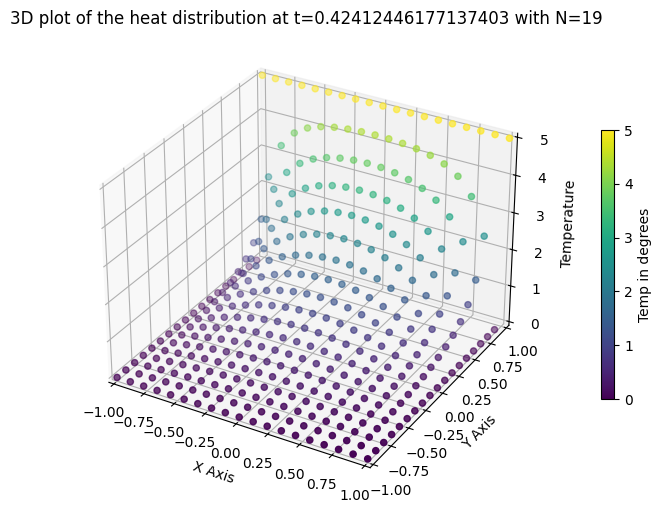

8.83 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


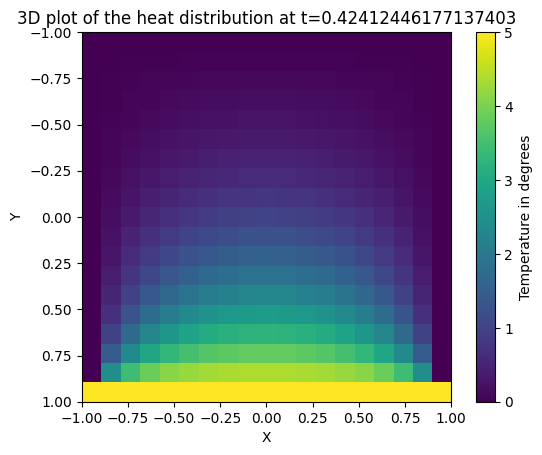

In [ ]:
%%timeit -n1 -r1
N=19
C=0.0038150007111020


U_imp, time_imp,Iter_imp,Center_Temp_imp = implicit_method_spsolver(N, C)
print("For explicit method, the computed t is ",time_exp, "for (0,0)\
        to reach u=1.")
print("For explicit method, the number of iteration is ",Iter_imp, "for\
         (0,0) to reach u=1.")

# 3D plot of the initial state at t=0
Plot_3D(N,U_imp,f"3D plot of the heat distribution at t={time_imp} with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U_imp,f"3D plot of the heat distribution at t={time_imp}")

#### Comment on Scipy's Spsolver implicit method
By choosing a small C and N=19, we have found the estimated time $t=0.42412446177137403$ when the center of the square plate reaches u=1 (after 9005 time step/iteration) and plotted the 2D & 3D plot of the square plate at that estimated time. This estimated time is correct up to 3dp when compare to the wanted $t_{*}=0.424011387033$.


#### **Scipy's Cgsolver with Incomplete LU Decomposition preconditioning (fast method)**
In this method, we have propagated the $u^{n}_{i,j}$ with the implicit iterative scheme where we have to solve the system of linear equation $M u^{n+1}_{i,j} = u^{n}_{i,j}$ using Scipy's Cgsolver within every loop.

In Preconditioned CG (PCG) Solver, LU decomposition can be used to compute the preconditioner
M which drastically improves convergence of the CG solver compare to Scipy's spsolver.

In [ ]:
def implicit_method_cg_precond(N,C):
    '''
    Evolving the system using explicit method until the centre of the square
    plate become u=1 and finding t

    input:
    N - number of evenly spaced grid points (discretisation parameter)
    C - Courant number

    Output:
    U - Heat distribution when the centre of the plate reaches u=1
    t - time when the centre of the plate reaches u=1
    Iteration_count - number of iteration to reach u=1
    '''

    # Setting up for explicit method
    N_imp=N
    h_imp = 2 / (N_imp- 1)  # Grid spacing
    # Choosing Time step such that Courant number is the one we set
    dt_imp = C * h_imp**2
    C_num_imp = dt_imp/h_imp**2

    # Heat distribution set-up for propagation via matrix implicit method
    U_imp=np.zeros((N_imp,N_imp))
    U_imp=Boundary_Condition(U_imp)



    # Constructing the M_matrix
    M_matrix = Matrix_M(N_imp,C)

    # time-tracking
    time_imp = 0.0

    # Counting number of iteration
    Iteration_count = 0

    # Tracking temperature of the center of the square plate
    Center_Temp = []

    # Preconditioner (Incomplete LU Decomposition)
    preconditioner = linalg.spilu(M_matrix)
    M_inv = linalg.LinearOperator(M_matrix.shape, preconditioner.solve)

    # using index convention (j*N+i) to get the index the centre point
    center_index = (N//2) * N + (N//2)

    # Treat U_imp as a vector
    U_imp_flat=U_imp.flatten()
    U_imp_update= U_imp_flat.copy()

    # Setting a while loop with condition to keep evolving until the centre of
    # the plate (0,0) reaches u=1
    while U_imp_update[center_index]<1:

        # Update Scheme with preconditioned CG
        U_imp_update, _ = linalg.cg(M_matrix, U_imp_update, M=M_inv)

        # Tracking Centre Temperature
        Center_Temp.append(U_imp_update[center_index])

        U_imp_flat = U_imp_update.copy()

        # Apply Boundary Condition on y=1 remaining at u=5
        U_imp_update= Boundary_Condition(U_imp_update.reshape(N_imp,N_imp))
        U_imp_update = U_imp_update.flatten()

        time_imp += dt_imp
        Iteration_count += 1

    # Final Heat Distribution reshape
    Final_U_imp= U_imp_flat.reshape((N_imp,N_imp))


    return Final_U_imp,time_imp,Iteration_count,Center_Temp



For explicit method, the computed t is  0.42445415319085217 for (0,0)        to reach u=1.
For explicit method, the number of iteration is  9012 for         (0,0) to reach u=1.


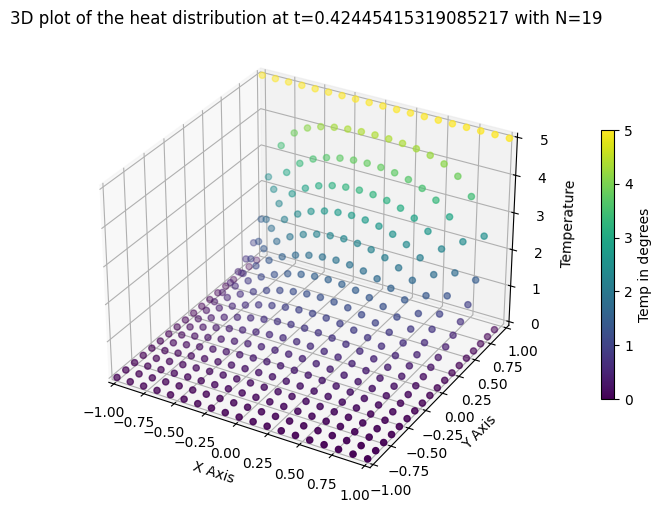

2.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


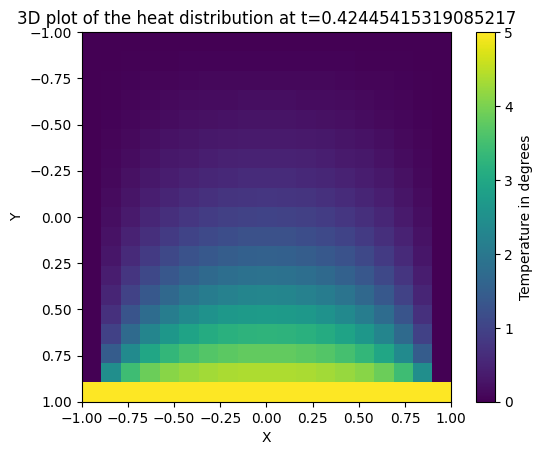

In [ ]:
%%timeit -n1 -r1
N=19
C=0.0038150007111020

U_imp_Cg,t_imp_Cg,Iter_imp_Cg,Center_Temp_imp_Cg=implicit_method_cg_precond(N,C)
print("For explicit method, the computed t is ",t_imp_Cg, "for (0,0)\
        to reach u=1.")
print("For explicit method, the number of iteration is ",Iter_imp_Cg, "for\
         (0,0) to reach u=1.")
# 3D plot of the initial state at t=0
Plot_3D(N,U_imp_Cg,f"3D plot of the heat distribution at t={t_imp_Cg} with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U_imp_Cg,f"3D plot of the heat distribution at t={t_imp_Cg}")

#### Comment on Scipy's Cgsolver (with Incomplete LU Decomposition preconditioning) implicit method
By choosing a small C and N=19, we have found the estimated time $t=0.42445415319085217$ when the center of the square plate reaches u=1 (after 9012 time step/iteration) and plotted the 2D & 3D plot of the square plate at that estimated time. This estimated time is correct up to 3dp when compare to the wanted $t_{*}=0.424011387033$.


#### **Comparing the Computational Performance of each method**
In this section, we will compare the computational time required to estimate the time t when the center of the square plate reaches u=1. For fair comparison, we fixed C and N to $N=19$ & $C=0.0038150007111020$ and plot the computational time of each methods on a bar chart.


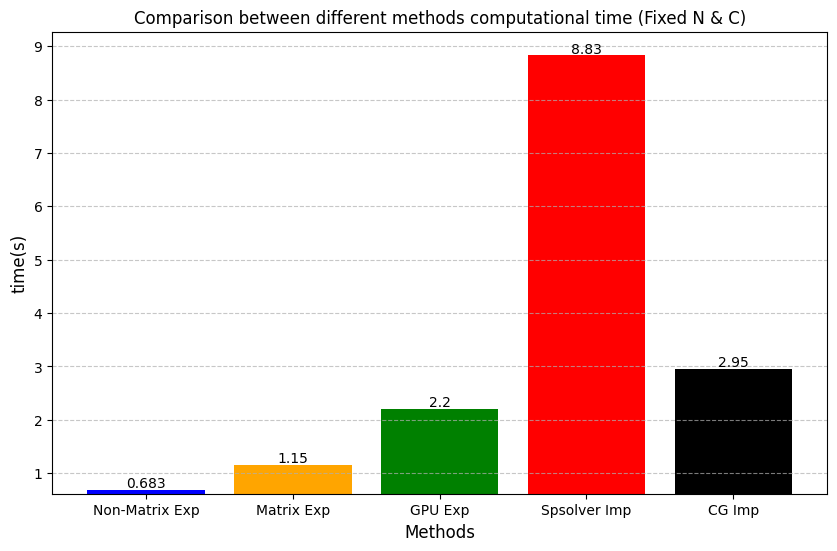

In [ ]:
# Plotting a bar chart to show the iteration for each method

name = ['Non-Matrix Exp', 'Matrix Exp', 'GPU Exp', 'Spsolver Imp', 'CG Imp']
time_comparison = [0.683, 1.15, 2.2, 8.83, 2.95]  # Ensure this matches the length of 'name'

plt.figure(figsize=(10, 6))
plt.bar(name, time_comparison, color=['blue', 'orange', 'green', 'red', 'black'])

plt.title('Comparison between different methods computational time (Fixed N & C)')
plt.xlabel('Methods', fontsize=12)
plt.ylabel('time(s)', fontsize=12)


# Zoom in to focus on the range of interest
plt.ylim(min(time_comparison) * 0.9, max(time_comparison) * 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(time_comparison):
    plt.text(i, v + max(time_comparison) * 0.005, str(v), ha='center', fontsize=10)
plt.show()

 #### Comment on the computational performance of each iteration schemes/ methods
 In general, we observed that the Implicit method is more computationally less performances than the Explciit method because of the fact that implicit method's equation is much harder to solve compare to the Explicit method's equation for time-stepping. For implicit method, we are able to drastically increase the computational performance by using Cg solver with incomplete LU decomposition as preconditioning. For explicit method, we observed that at small N (N=19), the non-matrix explicit method performed the best while the GPU implemented explicit method performed the worse. This is because at small N, the overhead associated with transferring data between the CPU and GPU, as well as initializing GPU computation, dominates the computational time, outweighing the advantages of GPU acceleration. In theory, Non-matrix & matrix explicit method should perform about the same but since non-matrix explicit method uses Numba's JIT (just-in-time), it is able to perform better. In the limit of large N, GPU implemented explicit method would be the best in terms of computational performance due to GPU acceleration/ parallel computing.

#### **Next Task: Numerically investigate the stability of your schemes**
In this Section of the note, we will investigate the stability of our schemes. In the explicit case, we expect the iterative scheme to be stable when the Courant number is less than or equal to 0.25 (as described previously in the "**Explicit Method**" section) due to the Courant-Friedrichs-Lewy (CFL) condition. While for the implicit case, we expect the iterative scheme to be unconditionally stable as described in the "**Implicit Method** section".

In [ ]:
# Fix N at 51
N=51

# set a value for C that is stable and non-stable
C_stable=0.25
C_non_stable=0.26

#### **Stability of Non-matrix explicit method**
Here we will investigate the stability of our non-matrix explicit method iterative scheme.

For explicit method, the computed t is  0.423600000000008 for (0,0)        to reach u=1.
For explicit method, the number of iteration is  1059 for         (0,0) to reach u=1.
1059


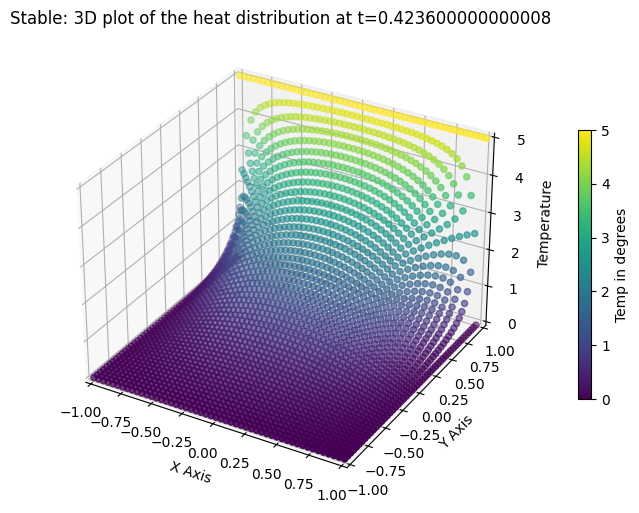

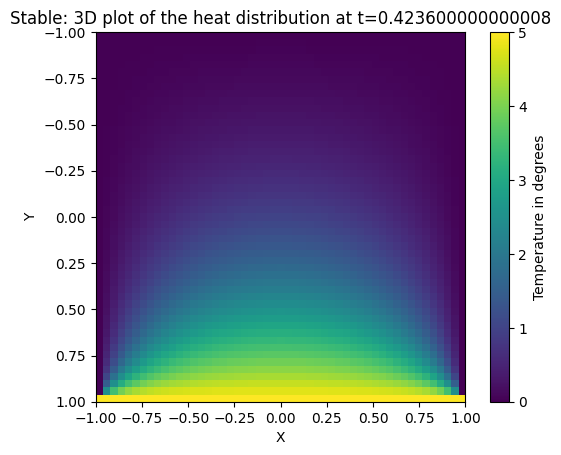

In [ ]:

U_exp,time_exp,Iteration_count,Center_Temp=explicit_method(N,C_stable)
print("For explicit method, the computed t is ",time_exp, "for (0,0)\
        to reach u=1.")
print("For explicit method, the number of iteration is ",Iteration_count, "for\
         (0,0) to reach u=1.")
print(len(Center_Temp))
# 3D plot of the initial state at t=0
Plot_3D(N,U_exp,f"Stable: 3D plot of the heat distribution at t={time_exp} ")
# 2D plot of the initial state at t=0
Plot_2D(U_exp,f"Stable: 3D plot of the heat distribution at t={time_exp}")

For explicit method, the computed t is  0.08361599999999995 for (0,0) to reach u=1.
For explicit method, the number of iteration is  201 for (0,0) to reach u=1.
201


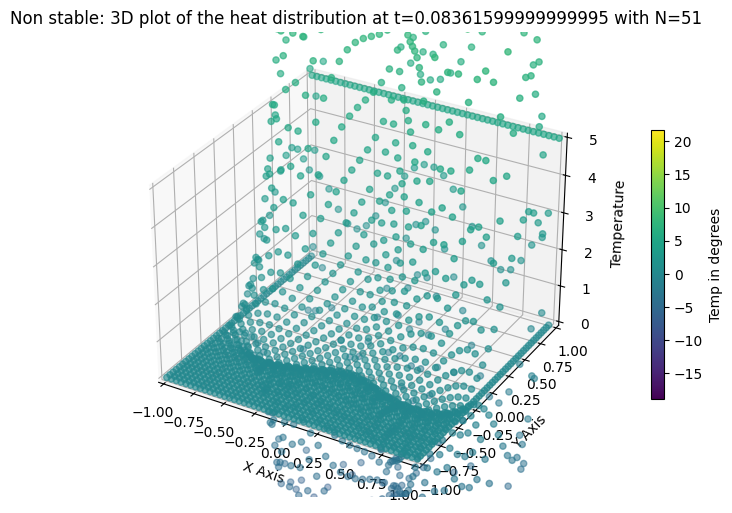

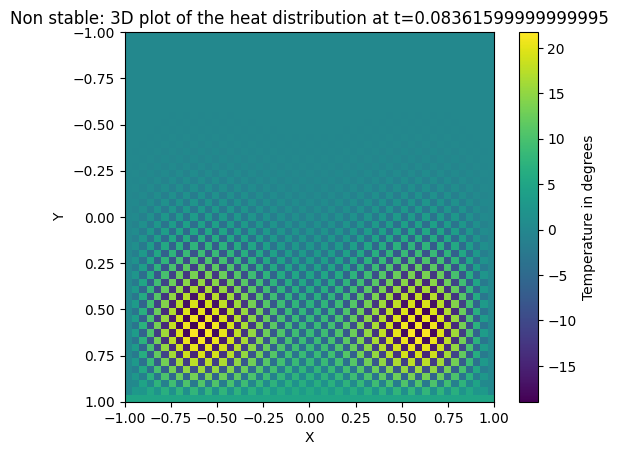

In [ ]:
U_exp,time_exp,Iteration_count,Center_Temp=explicit_method(N,C_non_stable)

print("For explicit method, the computed t is ",time_exp, "for (0,0) to reach\
             u=1.")
print("For explicit method, the number of iteration is ",Iteration_count, "for \
        (0,0) to reach u=1.")

# 3D plot of the initial state at t=0
Plot_3D(N,U_exp,f"Non stable: 3D plot of the heat distribution at t={time_exp} \
                with N={N}")

# 2D plot of the initial state at t=0
Plot_2D(U_exp,f"Non stable: 3D plot of the heat distribution at t={time_exp}")

#### **Stability of Matrix explicit method**
Here we will investigate the stability of our matrix explicit method iterative scheme.

The computed t is  0.423600000000008 for (0,0) to reach u=1.
The number of iteration is  1059 for (0,0) to reach u=1.
201


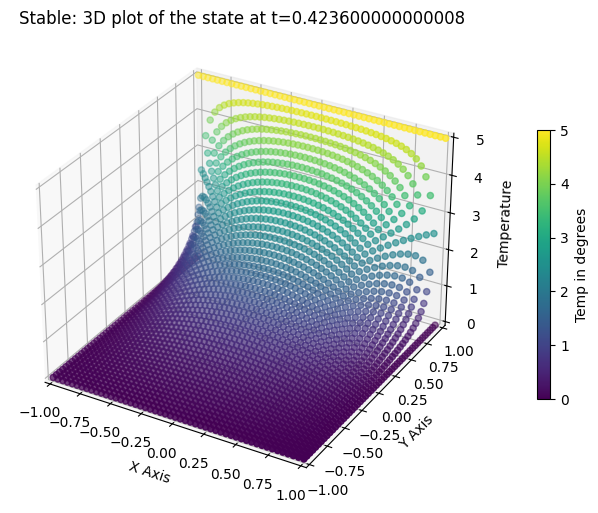

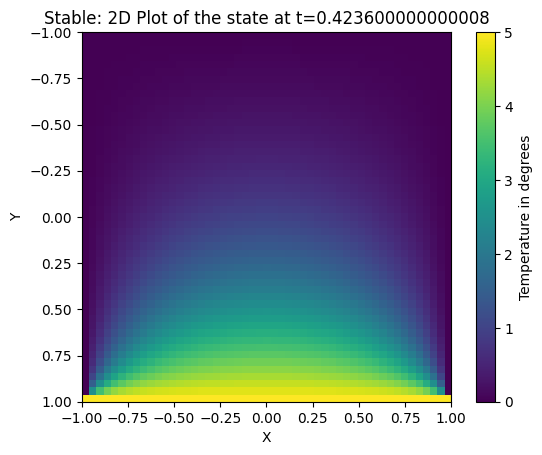

In [ ]:
U_exp_mat,time_exp_Mat,Iter_count_Mat,Center_Temp_mat_exp=explicit_matrix(N,\
                                                                      C_stable)
print("The computed t is ",time_exp_Mat, "for (0,0) to reach u=1.")
print("The number of iteration is ",Iter_count_Mat, "for (0,0) to reach u=1.")

# 3D plot of the initial state at t=0
Plot_3D(N,U_exp_mat,f"Stable: 3D plot of the state at t={time_exp_Mat}")
# 2D plot of the initial state at t=0
Plot_2D(U_exp_mat,f'Stable: 2D Plot of the state at t={time_exp_Mat}')

The computed t is  0.08361599999999995 for (0,0) to reach u=1.
The number of iteration is  201 for (0,0) to reach u=1.
201


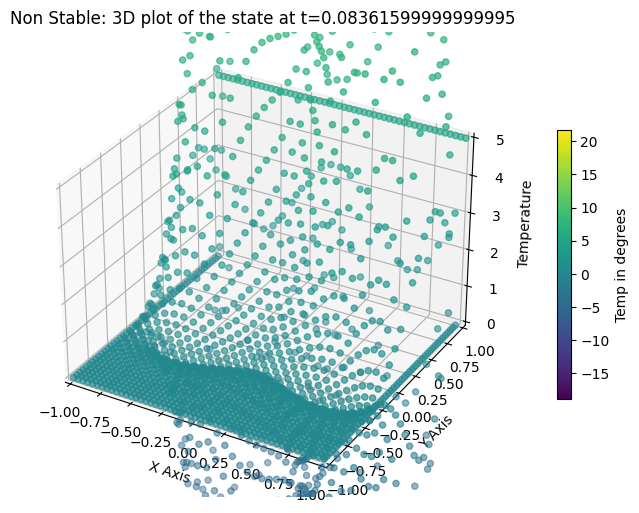

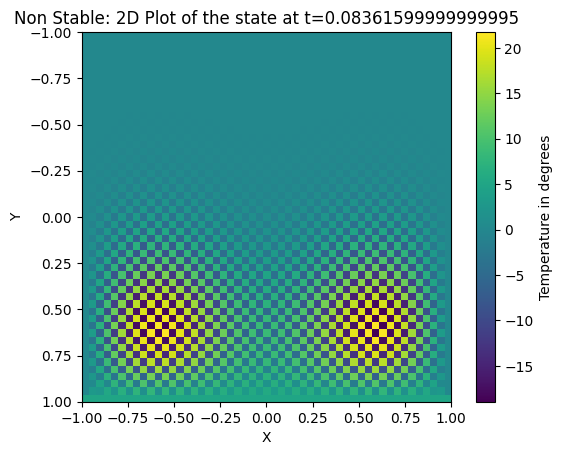

In [ ]:
U_exp_mat,time_exp_Mat,Iter_count_Mat,Center_Temp_mat_exp=explicit_matrix(N,\
                                                                  C_non_stable)

print("The computed t is ",time_exp_Mat, "for (0,0) to reach u=1.")
print("The number of iteration is ",Iter_count_Mat, "for (0,0) to reach u=1.")

# 3D plot of the initial state at t=0
Plot_3D(N,U_exp_mat,f"Non Stable: 3D plot of the state at t={time_exp_Mat}")
# 2D plot of the initial state at t=0
Plot_2D(U_exp_mat,f'Non Stable: 2D Plot of the state at t={time_exp_Mat}')

#### **Stability of GPU explicit method**
Here we will investigate the stability of our GPU explicit method iterative scheme.

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


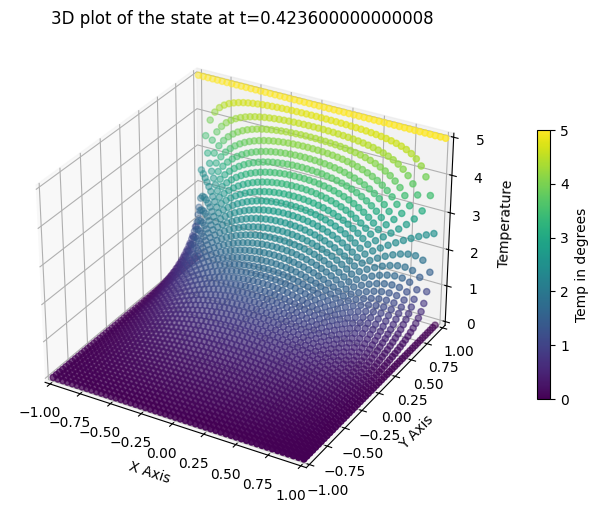

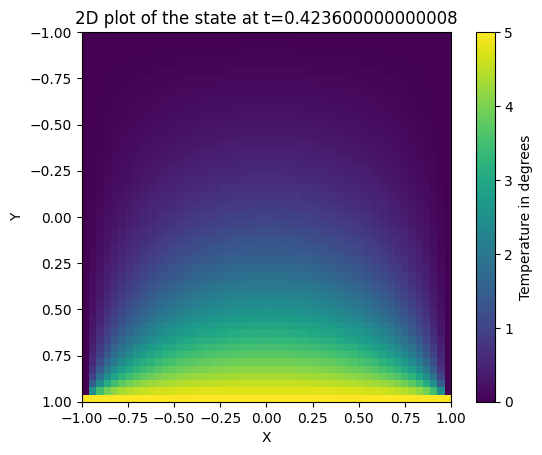

In [ ]:
u_explicit_gpu, t_explicit_gpu, iter_gpu,Center_Temp_gpu = GPU_explicit(N, \
                                                                      C_stable)

# 3D plot of the initial state at t=0
Plot_3D(N,u_explicit_gpu,f"3D plot of the state at t={t_explicit_gpu}")
# 2D plot of the initial state at t=0
Plot_2D(u_explicit_gpu,f"2D plot of the state at t={t_explicit_gpu}")

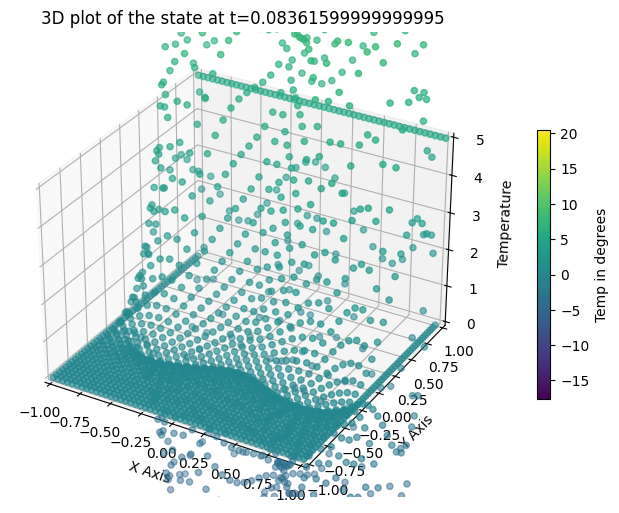

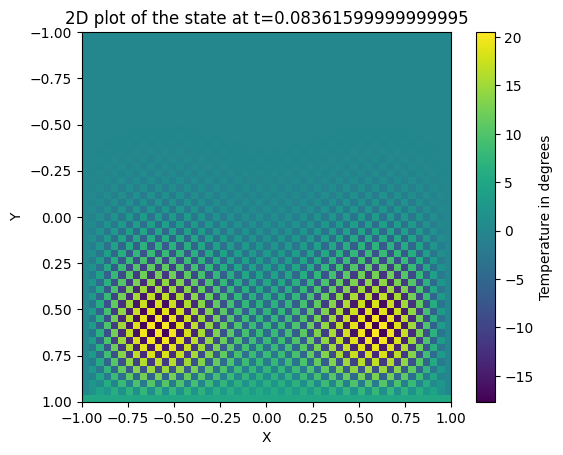

In [ ]:
u_explicit_gpu, t_explicit_gpu, iter_gpu,Center_Temp_gpu = GPU_explicit(N,\
                                                                  C_non_stable)

# 3D plot of the initial state at t=0
Plot_3D(N,u_explicit_gpu,f"3D plot of the state at t={t_explicit_gpu}")
# 2D plot of the initial state at t=0
Plot_2D(u_explicit_gpu,f"2D plot of the state at t={t_explicit_gpu}")

#### **Stability of implicit Scipy's Spsolver method**


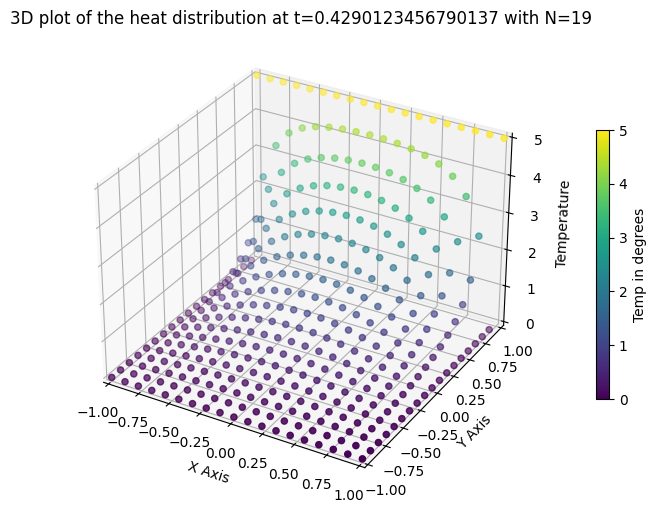

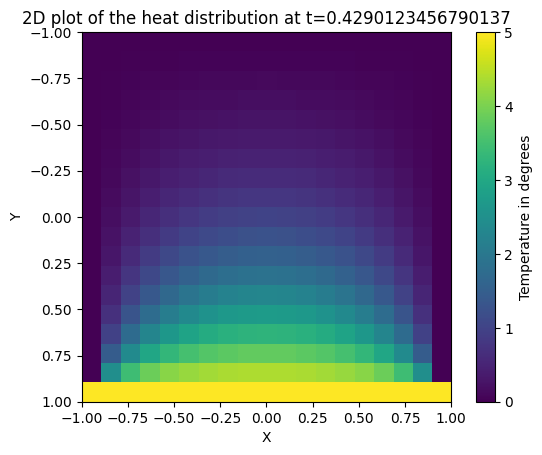

In [ ]:
U_imp, time_imp,Iter_imp,Center_Temp_imp = implicit_method_spsolver(N,\
                                                                    C_stable)

# 3D plot of the initial state at t=0
Plot_3D(N,U_imp,f"3D plot of the heat distribution at t={time_imp} with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U_imp,f"2D plot of the heat distribution at t={time_imp}")

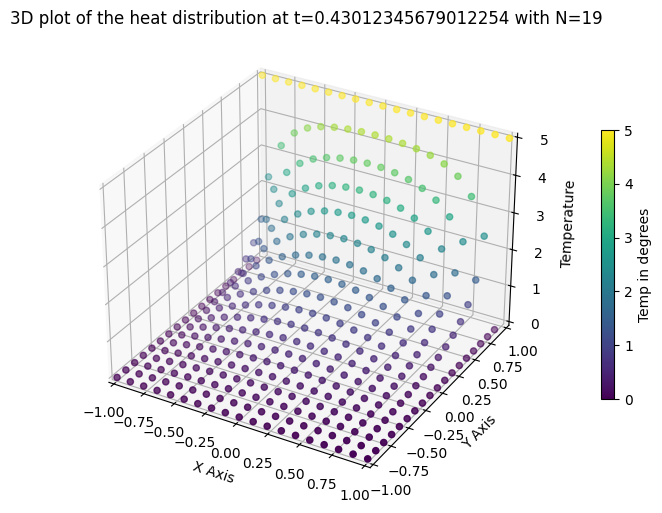

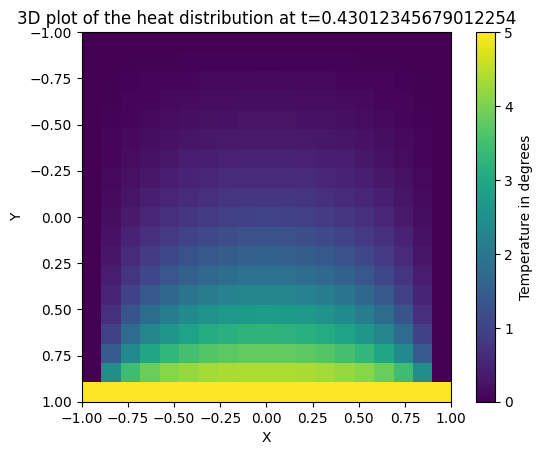

In [ ]:
U_imp, time_imp,Iter_imp,Center_Temp_imp = implicit_method_spsolver(N,\
                                                                  C_non_stable)

# 3D plot of the initial state at t=0
Plot_3D(N,U_imp,f"3D plot of the heat distribution at t={time_imp} with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U_imp,f"3D plot of the heat distribution at t={time_imp}")

#### **Stability of implicit CG precondition method**

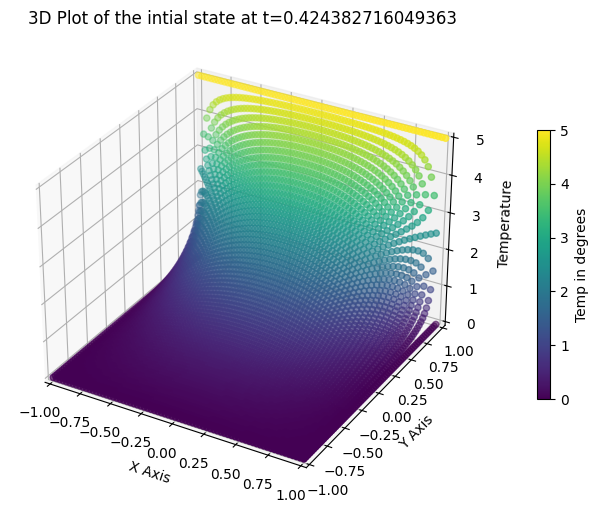

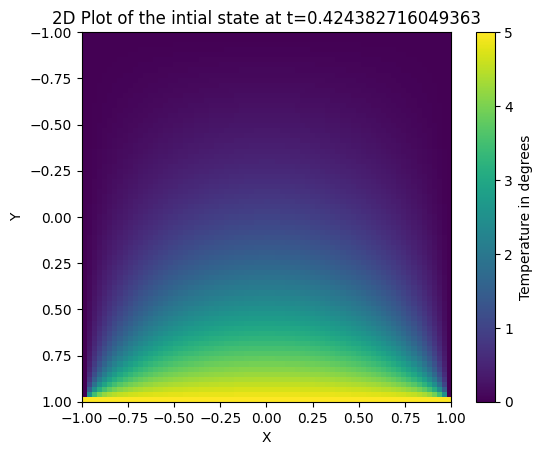

In [ ]:
U_imp_Cg,t_imp_Cg,Iter_imp_Cg,Center_Temp_imp_Cg=implicit_method_cg_precond(N,\
                                                                      C_stable)

Plot_3D(N,U_imp_Cg,f'3D Plot of the intial state at t={t_imp_Cg}')
# 2D plot of the initial state at t=0
Plot_2D(U_imp_Cg,f'2D Plot of the intial state at t={t_imp_Cg}')


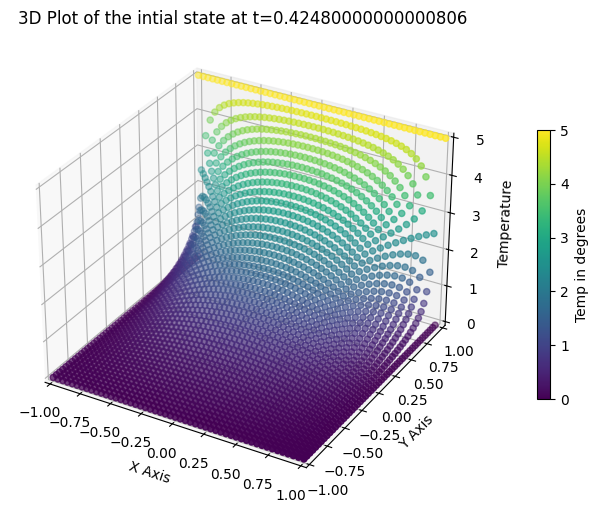

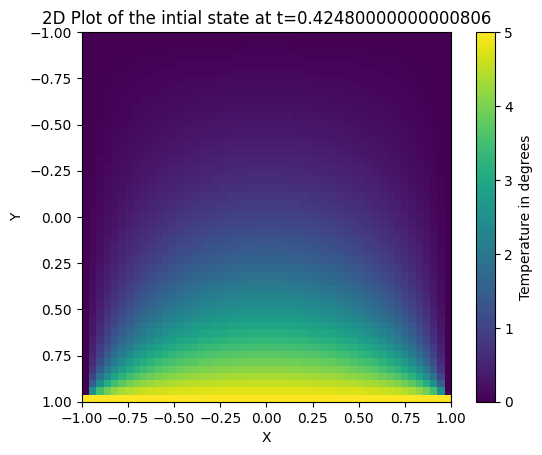

In [ ]:
U_imp_Cg,t_imp_Cg,Iter_imp_Cg,Center_Temp_imp_Cg=implicit_method_cg_precond(N,\
                                                                      C_stable)

Plot_3D(N,U_imp_Cg,f'3D Plot of the intial state at t={t_imp_Cg}')
# 2D plot of the initial state at t=0
Plot_2D(U_imp_Cg,f'2D Plot of the intial state at t={t_imp_Cg}')

#### Comment on the stability investigation
As shown above, the different types of method of the explicit iterative scheme all become unstable if C is bigger than 0.25. While the implicit iterative scheme is unconditionally stable. This result is in line with our expectation of our analysis of the stability of the explicit and implicit iterative schemes.

### **Convergence of t estimation**
**Task**: By increasing the number of discretisation points demonstrate how many correct digits you can achieve. Also, plot the convergence of your computed time $𝑡_{∗}$ against the actual time. To 12 digits the wanted solution is $𝑡_{∗}=0.424011387033$.

In this section, we have chosen a very small C=0.0038150007111020 (within stable Courant number) and we are able to achieve 11dp for explicit method while achieving 5dp for implicit method.



In [ ]:
C=0.003815000711102075

t_est_non_mat_exp = []
t_est_mat_exp = []
t_est_gpu_exp = []
t_est_imp_cg = []

trial_N = np.arange(7,103,2)


for N in trial_N:

  # Looping through non-matrix explicit method
  U_exp,time_exp,Iteration_count,Center_Temp=explicit_method(N,C)
  t_est_non_mat_exp.append(time_exp)

  # Looping through matrix explicit method
  U_exp_mat,time_exp_Mat,Iter_count_Mat,Center_Temp_mat_exp=explicit_matrix(N,C)
  t_est_mat_exp.append(time_exp_Mat)

  # Looping through GPU explicit method
  u_explicit_gpu, t_explicit_gpu, iter_gpu,Center_Temp_gpu = GPU_explicit(N,C)
  t_est_gpu_exp.append(t_explicit_gpu)

  U_imp_Cg,t_imp_Cg,Iter_imp_Cg,Center_Temp_imp_Cg=implicit_method_cg_precond(N,C)
  t_est_imp_cg.append(t_imp_Cg)



/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
Non_matrix_Iter_C2 = Iteration_count
Matrix_Iter_C2 = Iter_count_Mat
GPU_Iter_C2 =  iter_gpu
Imp_cg_Iter_C2 = Iter_imp_Cg

In [ ]:

# Computing the residual (difference between the estimate t and the actual t*)
t_real = 0.424011387033
residual_non_mat_exp=[]
residual_mat_exp = []
residual_gpu_exp = []
residual_imp_cg = []

for i in t_est_non_mat_exp:
    res = abs(i-t_real)
    residual_non_mat_exp.append(res)

for i in t_est_mat_exp:
    res = abs(i-t_real)
    residual_mat_exp.append(res)

for i in t_est_gpu_exp:
    res = abs(i-t_real)
    residual_gpu_exp.append(res)

for i in t_est_imp_cg:
    res = abs(i-t_real)
    residual_imp_cg.append(res)

#### Plotting the residual and time estimation for each method
For each method, we plot the time estimation which is the time when the center of the square plate reaches u=1. We also plot the residual which is defined as the difference between the time estimation and the wanted solution is $𝑡_{*}=0.424011387033$.

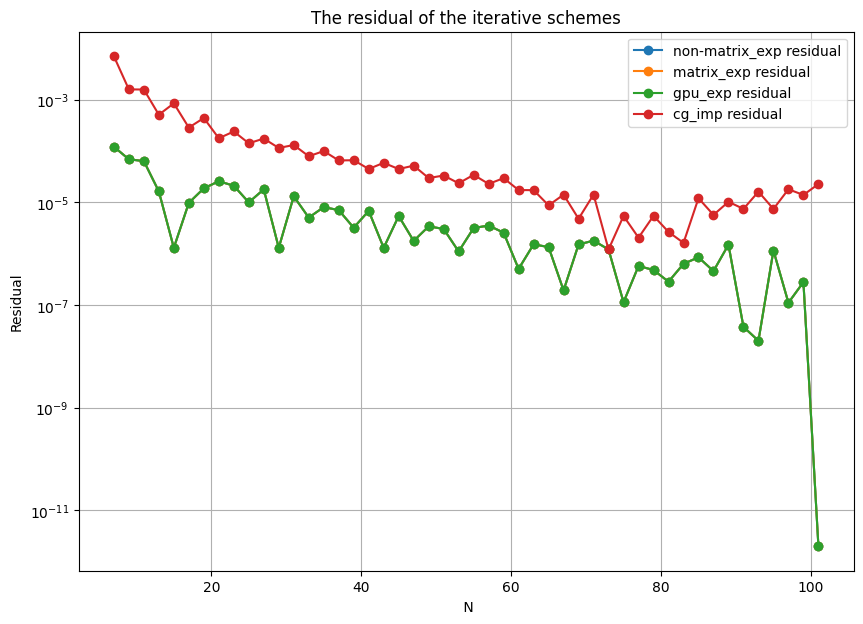

In [ ]:
fig,ax2=plt.subplots(figsize=(10,7))

ax2.plot(trial_N,residual_non_mat_exp ,"-o", label="non-matrix_exp residual")
ax2.plot(trial_N,residual_mat_exp ,"-o", label="matrix_exp residual")
ax2.plot(trial_N,residual_gpu_exp,"-o", label="gpu_exp residual")
ax2.plot(trial_N,residual_imp_cg,"-o", label="cg_imp residual")

ax2.set_ylabel("Residual")

ax2.set_xlabel(' N')

ax2.set_yscale('log')
ax2.set_title('The residual of the iterative schemes')
plt.legend()
plt.grid()
plt.show()

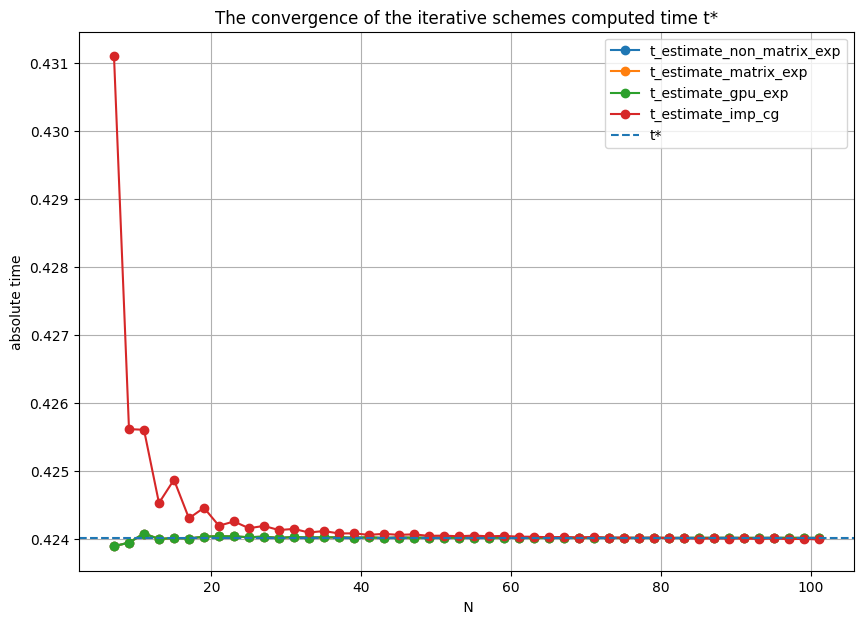

In [ ]:
fig,ax2=plt.subplots(figsize=(10,7))

#ax2.plot(trial_N[1:], t_est_non_mat_exp[1:],"-o", label="t_estimate_non_matrix_exp")
#ax2.plot(trial_N[1:], t_est_mat_exp[1:],"-o", label="t_estimate_matrix_exp")
#ax2.plot(trial_N[1:], t_est_gpu_exp[1:],"-o", label="t_estimate_gpu_exp")
#ax2.plot(trial_N[1:], t_est_imp_cg[1:],"-o", label="t_estimate_imp_cg")

ax2.plot(trial_N, t_est_non_mat_exp,"-o", label="t_estimate_non_matrix_exp")
ax2.plot(trial_N, t_est_mat_exp,"-o", label="t_estimate_matrix_exp")
ax2.plot(trial_N, t_est_gpu_exp,"-o", label="t_estimate_gpu_exp")
ax2.plot(trial_N, t_est_imp_cg,"-o", label="t_estimate_imp_cg")

ax2.axhline(t_real, linestyle='--',label="t*")
ax2.set_ylabel("absolute time")

ax2.set_xlabel(' N')
ax2.set_title('The convergence of the iterative schemes computed time t*')


plt.legend()
plt.grid()
plt.show()

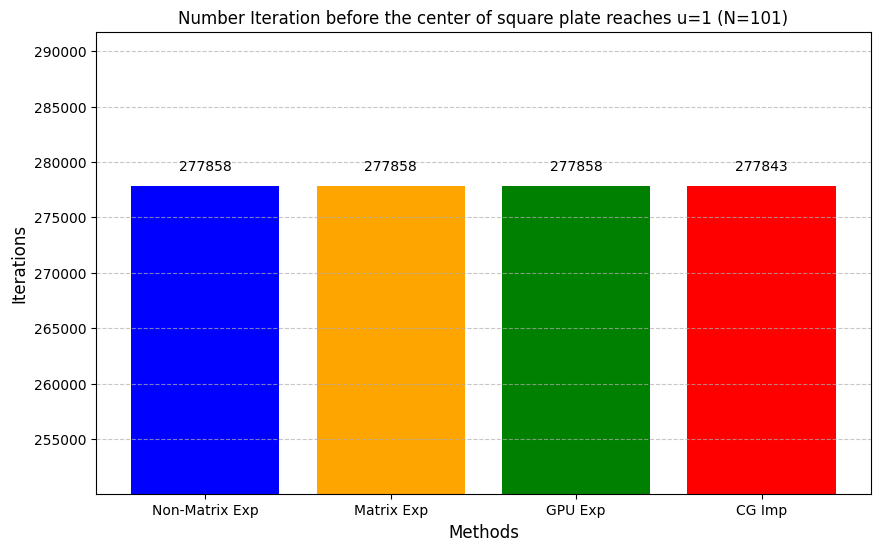

In [ ]:
# Plotting a bar chart to show the iteration for each method

name = ['Non-Matrix Exp', 'Matrix Exp', 'GPU Exp', 'CG Imp']
iteration = [Non_matrix_Iter_C2, Matrix_Iter_C2, GPU_Iter_C2, Iter_imp_Cg]

plt.figure(figsize=(10, 6))
plt.bar(name, iteration, color=['blue', 'orange', 'green', 'red'])
plt.title('Number Iteration before the center of square plate reaches u=1 (N=101)')
plt.xlabel('Methods', fontsize=12)
plt.ylabel('Iterations', fontsize=12)
# Zoom in to focus on the range of interest
plt.ylim(min(iteration) * 0.9, max(iteration) * 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(iteration):
    plt.text(i, v + max(iteration) * 0.005, str(v), ha='center', fontsize=10)
plt.show()

#### Comment on convergence
As shown on the residual plot with title "residuals of the iterative schemes", we have shown that all explicit method have the same residual and that the explicit method's residual is always less than the implicit method's residual. In the convergence plot with title "convergence of the iterative schemes computed time $t_{*}$", both implicit and explicit converge to the wanted solution $t_{*}==0.424011387033$. In the plot with title "Number Iteration before the center of square plate reaches u=1 (N=101)", we plotted a bar chart showing the number of iteration required for each iterative schemes/ methods to find $t_{*}$ when N=101 & C=0.0038150007111020.

#### **Demonstrate how many correct digits you can achieve using Explicit method & Implicit method**
By choosing C=0.0038150007111020, we are able to achieve a time estimation that is correct up to 11dp for the explicit method. Since all explicit methods (non-matrix, matrix, GPU) gives the same exact time estimation, we will just give the best time estimation and plot the state (heat distribution) for one of the method (non-matrix explicit method). Also, we are able to achieve a time estimation that is correct up to 5dp for the implicit method.

From the residual of the iterative schemes graph, we can see that both explicit and implicit method reaches minimum residual at N=101 & N=73 respectively.

#### GPU Explicit Method

For explicit method, the computed t is  0.42401138703099556 for (0,0)        to reach u=1.
For explicit method, the number of iteration is  277858 for         (0,0) to reach u=1.


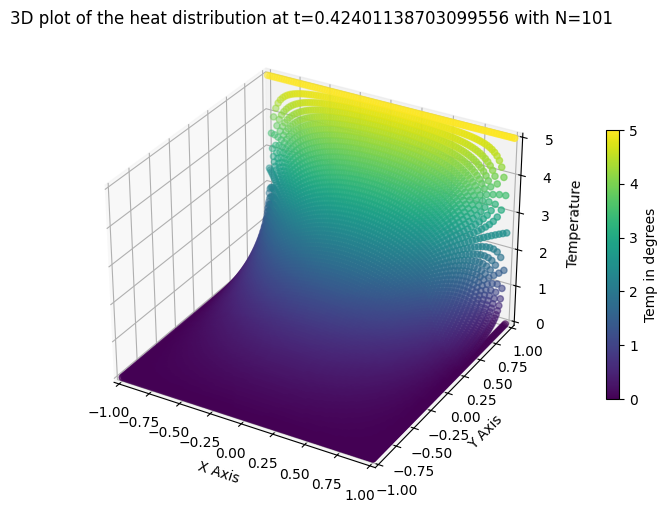

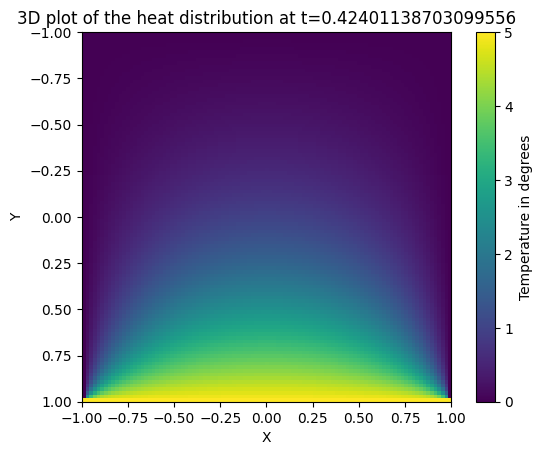

In [ ]:
N=101
C=0.0038150007111020


U_exp,time_exp,Iteration_count,Center_Temp=explicit_method(N,C)
print("For explicit method, the computed t is ",time_exp, "for (0,0)\
        to reach u=1.")
print("For explicit method, the number of iteration is ",Iteration_count, "for\
         (0,0) to reach u=1.")
# 3D plot of the initial state at t=0
Plot_3D(N,U_exp,f"3D plot of the heat distribution at t={time_exp} with N={N}")
# 2D plot of the initial state at t=0
Plot_2D(U_exp,f"3D plot of the heat distribution at t={time_exp}")

#### Cgsolver implicit method

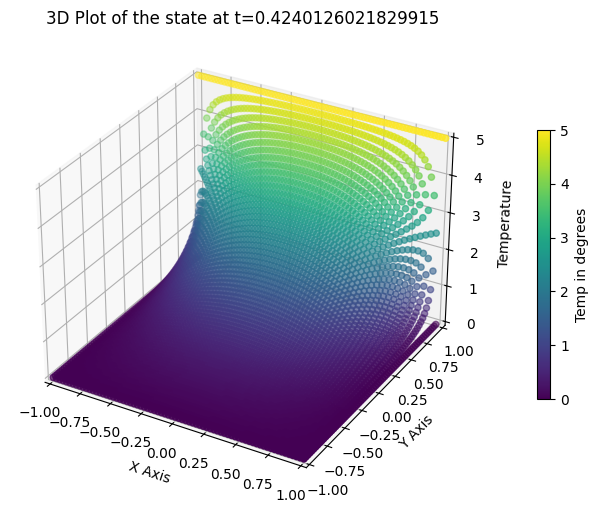

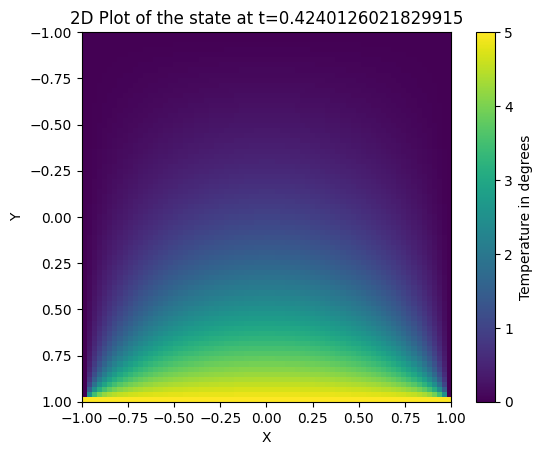

In [ ]:
C=0.0038150007111020
N=73

U_imp_Cg,t_imp_Cg,Iter_imp_Cg,Center_Temp_imp_Cg=implicit_method_cg_precond(N,C)

Plot_3D(N,U_imp_Cg,f'3D Plot of the state at t={t_imp_Cg}')
# 2D plot of the initial state at t=0
Plot_2D(U_imp_Cg,f'2D Plot of the state at t={t_imp_Cg}')


#### Investigate the effect of Courant Number (C)
To investigate the effect of Courant number (C), we first fix N at N=101 and vary C. C will affect the number of iteration required for the center of the square plate to reach u=1 because C affect dt (time-step):
$$dt = C * \frac{4} {(N-1)^{2}}$$

In theory, we will expect the residual to decrease for smaller C due to smaller dt resulting in  the simulation taking smaller steps forward in time. Smaller time-steps reduce truncation errors, which are the errors introduced when approximating derivatives using finite differences. Hence we expect the residual to trend lower at high number of iteration on a plot of residual vs number of iteration.

In [ ]:
# Generate more points near 0.002
C= np.linspace(0.002, 0.25, 100)
N=101

t_est_non_mat_exp_C = []
t_est_mat_exp_C = []
t_est_gpu_exp_C = []
t_est_imp_cg_C = []

Iteration_non_mat_exp=[]
Iteration_mat_exp=[]
Iteration_gpu_exp=[]




for i in C:

  # Looping through non-matrix explicit method
  U_exp,time_exp,Iteration_count,Center_Temp=explicit_method(N,i)
  t_est_non_mat_exp_C.append(time_exp)
  Iteration_non_mat_exp.append(Iteration_count)

  # Looping through matrix explicit method
  U_exp_mat,time_exp_Mat,Iter_count_Mat,Center_Temp_mat_exp=explicit_matrix(N,i)
  t_est_mat_exp_C.append(time_exp_Mat)
  Iteration_mat_exp.append(Iter_count_Mat)

  # Looping through GPU explicit method
  u_explicit_gpu, t_explicit_gpu, iter_gpu,Center_Temp_gpu = GPU_explicit(N,i)
  t_est_gpu_exp_C.append(t_explicit_gpu)
  Iteration_gpu_exp.append(iter_gpu)

In [ ]:
# Computing the residual (difference between the estimate t and the actual t*)
t_real = 0.424011387033
residual_non_mat_exp_C=[]
residual_mat_exp_C = []
residual_gpu_exp_C = []
#residual_imp_cg_C = []



for i in t_est_non_mat_exp_C:
    res = abs(i-t_real)
    residual_non_mat_exp_C.append(res)

for i in t_est_mat_exp_C:
    res = abs(i-t_real)
    residual_mat_exp_C.append(res)

for i in t_est_gpu_exp_C:
    res = abs(i-t_real)
    residual_gpu_exp_C.append(res)



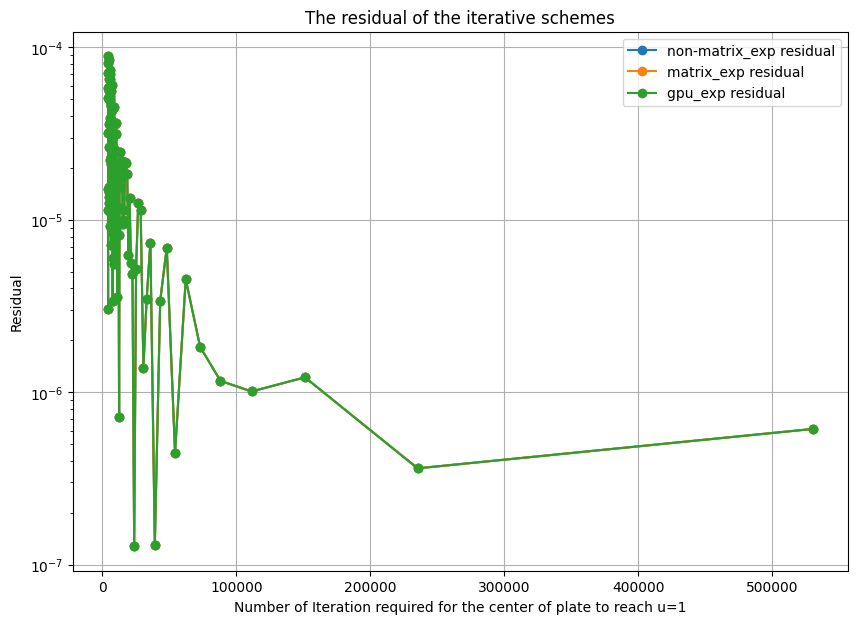

In [ ]:
fig,ax2=plt.subplots(figsize=(10,7))


ax2.plot(Iteration_non_mat_exp,residual_non_mat_exp_C ,"-o", label="non-matrix_exp residual")
ax2.plot(Iteration_mat_exp,residual_mat_exp_C ,"-o", label="matrix_exp residual")
ax2.plot(Iteration_gpu_exp,residual_gpu_exp_C,"-o", label="gpu_exp residual")
#ax2.plot(trial_N,residual_imp_cg,"-o", label="cg_imp residual")

ax2.set_ylabel("Residual")

ax2.set_xlabel('Number of Iteration required for the center of plate to reach u=1')

ax2.set_yscale('log')
ax2.set_title('The residual of the iterative schemes')
plt.legend()
plt.grid()
plt.show()

#### Comment on the effect of Courant Number (C)
We are able to show that for smaller C, the estimate time t does converge towards the wanted solution $t_{*}=0.424011387033$ with residual hovering at roughly $10^{-6}$. Due to time constraint, we are not able to plot the cgsolver_imp residual. But we expect that its trend will be very similar to explicit method.

## **Conclusion**

We have achieve a time estimation that is correct up to 11dp for the explicit method compare to the wanted solution $t_{*}=0.424011387033$. Also, we are able to achieve a time estimation that is correct up to 5dp for the implicit method. We have shown the convergence of our explicit and implicit methods.